In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import openpyxl as xl
from datetime import timedelta
import numpy as np

/home/abbymoreno/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# LGU Health Data Preparation

In this notebook, we will be aggregating and doing a quick EDA on a sample LGU dataset which is Zamboanga.

In [2]:
LGU_DIR = Path("../../data/02-raw/health/LGU/Zamboanga/")

ADMIN_BOUNDS = Path("../../data/01-admin-bounds/target_admin_bounds.shp")

## Load Zamboanga Table

In [3]:
# load excel file and check sheet names
cases_file = xl.load_workbook(LGU_DIR / "Copy of PIDSR ARCHIVE_EpiMetrics.xlsx")
print(cases_file.sheetnames)

['ABD_', 'AES_', 'AFP_', 'AHF_', 'AMES_', 'CHOLERA_', 'ChikV_', 'DENGUE_', 'DIPH_', 'HEPATITIS_', 'HFMD_', 'ILI_', 'LEPTOSPIROSIS_', 'MALARIA_', 'MEASLES_', 'MENINGITIS_', 'MENINGO_', 'NNT_', 'NT_', 'PERT_', 'RABIES_', 'TYPHOID_']


In [4]:
# load sheet needed for pandas
# in this sample EDA we will only work with Dengue
dengue_df = pd.read_excel(
    LGU_DIR / "Copy of PIDSR ARCHIVE_EpiMetrics.xlsx", sheet_name="DENGUE_"
)
dengue_df.head(3)

,Region,Province,Muncity,AgeYears,Sex,Admitted,DAdmit,DOnset,Type,ClinClass,CaseClassification,Outcome,DateDied,Icd10Code,MorbidityMonth,MorbidityWeek,Year,Barangay
0,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,15.083333,F,1,2013-01-05,2012-12-31,DHF,NaN,P,A,NaN,A90,1,1,2013,BOALAN
1,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,6.583333,M,1,2013-01-02,2012-12-29,DF,NaN,S,A,NaN,A90,1,1,2013,SANTA BARBARA
2,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,2.500000,M,1,2013-01-02,2012-12-29,DHF,NaN,S,A,NaN,NaN,1,1,2013,PASONANCA


In [5]:
dengue_df["MorbidityWeek"].unique()

array([ 1,  2,  3, 13,  4, 10,  9,  8,  5,  6,  7, 21, 11, 12, 31, 32, 33,
       14, 15, 16, 17, 18, 19, 20, 22, 26, 25, 24, 27, 23, 28, 30, 29, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [6]:
dengue_df.shape  # number of cases

(25237, 18)

Check if all date columns are populated.

In [7]:
dengue_df["DAdmit"].isna().value_counts()

False    25237
Name: DAdmit, dtype: int64

In [8]:
dengue_df["DOnset"].isna().value_counts()

False    24386
True       851
Name: DOnset, dtype: int64

## Prep LGU Data

### Add start of week date

Use hospitalization (DAdmit) as basis and also this date column has no nulls.

In [9]:
dengue_df["DAdmit"] = pd.to_datetime(dengue_df["DAdmit"])

In [10]:
# Get start of the week
dengue_df["start_of_week"] = dengue_df["DAdmit"] - pd.to_timedelta(
    dengue_df["DAdmit"].dt.dayofweek, unit="D"
)

# # Check if the Monday is from the previous year (December)
previous_year_mask = dengue_df["start_of_week"].dt.year < dengue_df["DAdmit"].dt.year

# # Adjust the start of the week to the current year
dengue_df.loc[previous_year_mask, "start_of_week"] = pd.to_datetime(
    dengue_df[previous_year_mask]["DAdmit"].dt.year, format="%Y"
)

dengue_df.head(3)

,Region,Province,Muncity,AgeYears,Sex,Admitted,DAdmit,DOnset,Type,ClinClass,CaseClassification,Outcome,DateDied,Icd10Code,MorbidityMonth,MorbidityWeek,Year,Barangay,start_of_week
0,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,15.083333,F,1,2013-01-05,2012-12-31,DHF,NaN,P,A,NaN,A90,1,1,2013,BOALAN,2013-01-01
1,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,6.583333,M,1,2013-01-02,2012-12-29,DF,NaN,S,A,NaN,A90,1,1,2013,SANTA BARBARA,2013-01-01
2,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,2.500000,M,1,2013-01-02,2012-12-29,DHF,NaN,S,A,NaN,NaN,1,1,2013,PASONANCA,2013-01-01


In [11]:
dengue_df["Barangay"].nunique()

100

### Add Age Categories

Follow grouping in the unfinished consolidation sheet.

In [12]:
bins = [0, 1, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, np.inf]
names = [
    "<1",
    "1-4",
    "5-9",
    "10-14",
    "15-19",
    "20-24",
    "25-29",
    "30-34",
    "35-39",
    "40-44",
    "45-49",
    "50-54",
    "55-59",
    "60-64",
    "65-69",
    "70+",
]

dengue_df["Age_Category"] = pd.cut(dengue_df["AgeYears"], bins, labels=names)
# Manually adjust "<1" and "1-4" categories
dengue_df.loc[dengue_df["AgeYears"] == 1, "Age_Category"] = "1-4"

In [13]:
dengue_df[["AgeYears", "Age_Category"]]

,AgeYears,Age_Category
0,15.083333,15-19
1,6.583333,5-9
2,2.500000,1-4
3,7.250000,5-9
4,6.583333,5-9
...,...,...
25232,24.000000,20-24
25233,10.000000,10-14
25234,7.000000,5-9
25235,4.000000,1-4


### Add PSGC Codes

In [14]:
aoi = gpd.read_file(ADMIN_BOUNDS)
aoi.head(2)

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053..."
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039..."


In [15]:
# Admin Boundary area columns

# List of columns to lowercase
aoi_area_cols = ["ADM2_EN", "ADM3_EN", "ADM4_EN"]

# Use applymap() to apply lowercase transformation to specified columns
aoi[aoi_area_cols] = aoi[aoi_area_cols].applymap(str.lower)

Apparently, there are rows that have no "Barangay" names. Remove these rows.

In [16]:
dengue_df = dengue_df[~dengue_df["Barangay"].isna()]

In [17]:
# LGU data area columns

# List of columns to lowercase
lgu_area_cols = ["Province", "Muncity", "Barangay"]

# Use applymap() to apply lowercase transformation to specified columns
dengue_df[lgu_area_cols] = dengue_df[lgu_area_cols].applymap(str.lower)

In [18]:
dengue_df.shape

(24936, 20)

In [19]:
dengue_w_aoi = dengue_df.merge(aoi, left_on=lgu_area_cols, right_on=aoi_area_cols)
dengue_w_aoi = dengue_w_aoi.drop(
    columns=[
        "ADM1_EN",
        "ADM1_PCODE",
        "ADM2_EN",
        "ADM2_PCODE",
        "ADM3_EN",
        "ADM3_PCODE",
        "ADM4_EN",
        "geometry",
    ]
)
dengue_w_aoi.head(3)

,Region,Province,Muncity,AgeYears,Sex,Admitted,DAdmit,DOnset,Type,ClinClass,...,Outcome,DateDied,Icd10Code,MorbidityMonth,MorbidityWeek,Year,Barangay,start_of_week,Age_Category,ADM4_PCODE
0,9,zamboanga del sur,zamboanga city,15.083333,F,1,2013-01-05,2012-12-31,DHF,NaN,...,A,NaN,A90,1,1,2013,boalan,2013-01-01,15-19,PH097332010
1,9,zamboanga del sur,zamboanga city,6.583333,M,1,2013-01-01,2012-12-29,DSS,NaN,...,A,NaN,NaN,1,1,2013,boalan,2013-01-01,5-9,PH097332010
2,9,zamboanga del sur,zamboanga city,8.250000,F,1,2013-02-28,2013-02-25,N,NaN,...,A,NaN,A90,2,9,2013,boalan,2013-02-25,5-9,PH097332010


Only two cases were not matched

In [20]:
dengue_w_aoi.shape

(24934, 21)

In [21]:
dengue_w_aoi["ADM4_PCODE"].nunique()

97

## Visualizations of Cases

### Number of Cases over time

Aggregate by Date for now.

In [23]:
agg_dengue_df = dengue_df.groupby(["start_of_week"]).size().reset_index(name="NumCases")
# add week date

agg_dengue_df

,start_of_week,NumCases
0,2013-01-01,66
1,2013-01-07,77
2,2013-01-14,83
3,2013-01-21,75
4,2013-01-28,85
...,...,...
470,2021-11-29,27
471,2021-12-06,26
472,2021-12-13,35
473,2021-12-20,27


In [24]:
# get summary stats
agg_dengue_df.describe()

,NumCases
count,475.000000
mean,52.496842
std,53.738128
min,1.000000
25%,16.500000
50%,41.000000
75%,71.000000
max,391.000000


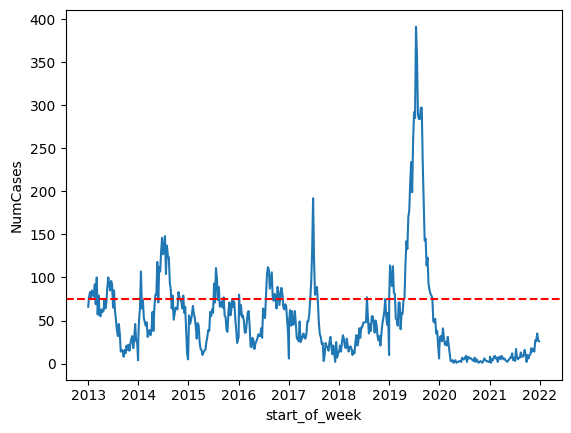

In [25]:
sns.lineplot(x="start_of_week", y="NumCases", data=agg_dengue_df)

# Add a horizontal line for the threshold
plt.axhline(75, color="red", linestyle="--", label="Threshold")
# Show the plot
plt.show()

In [ ]:
# Define the threshold
threshold = 75

# Extract unique years from the 'start_of_week' column
years = agg_dengue_df["start_of_week"].dt.year.unique()

y_min = agg_dengue_df["NumCases"].min()
y_max = agg_dengue_df["NumCases"].max()

# Calculate the number of rows and columns for subplots
num_rows = len(years) // 2 + (len(years) % 2)  # Adjust for odd number of years
num_cols = 2

# Create a single figure with subplots arranged in two columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))

# Flatten the axes array for ease of indexing
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    if i >= len(years):
        ax.axis("off")  # Turn off unused subplots
        continue

    ax.set_title(f"Dengue Cases in {year}")

    # Filter the data for the current year
    year_data = agg_dengue_df[agg_dengue_df["start_of_week"].dt.year == year]

    # Create a Seaborn line plot for the current year's data
    sns.lineplot(
        x="start_of_week",
        y="NumCases",
        data=year_data,
        marker="o",
        label="NumCases",
        ax=ax,
    )

    # Add a horizontal line for the threshold
    ax.axhline(threshold, color="red", linestyle="--", label="Threshold")
    ax.set_ylim(y_min, y_max)

    # Customize the plot
    ax.set_xlabel("Start of Week")
    ax.set_ylabel("Number of Cases")
    ax.legend()

# Adjust the layout to prevent overlap of subplots
plt.tight_layout()

# Show the combined figure with subplots
plt.show()

### Trends of cases per sex

Check if there will be a difference in trend for age groups. If no difference, then proceed as is with aggregation of cases. If there is a difference, then might need to consider creating a separate model.

In [28]:
agg_sex_dengue_df = (
    dengue_df.groupby(["start_of_week", "Sex"]).size().reset_index(name="NumCases")
)
agg_sex_dengue_df

,start_of_week,Sex,NumCases
0,2013-01-01,F,28
1,2013-01-01,M,38
2,2013-01-07,F,34
3,2013-01-07,M,43
4,2013-01-14,F,38
...,...,...,...
928,2021-12-13,M,18
929,2021-12-20,F,13
930,2021-12-20,M,14
931,2021-12-27,F,13


Different sex does not vary on the historical trend. No need for separate models.

In [ ]:
sns.lineplot(x="start_of_week", y="NumCases", hue="Sex", data=agg_sex_dengue_df)

### Plot by Age group

Check if trends would vary for different age groups

In [30]:
dengue_df["Age_Category"].value_counts()

5-9      6146
10-14    4787
1-4      3683
15-19    3431
20-24    1947
25-29    1235
30-34     798
<1        635
35-39     527
40-44     408
45-49     299
50-54     267
55-59     212
70+       203
60-64     185
65-69     146
Name: Age_Category, dtype: int64

In [31]:
agg_age_dengue_df = (
    dengue_df.groupby(["start_of_week", "Age_Category"])
    .size()
    .reset_index(name="NumCases")
)
agg_age_dengue_df.head(3)

,start_of_week,Age_Category,NumCases
0,2013-01-01,<1,2
1,2013-01-01,1-4,4
2,2013-01-01,5-9,14


In [ ]:
sns.lineplot(
    x="start_of_week", y="NumCases", hue="Age_Category", data=agg_age_dengue_df
)
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.show()

## Setting the definition of Threshold

EM recommendation for threshold: 75th percentile of top 10 municipalities. 

In [33]:
brgy_weekly = (
    dengue_w_aoi.groupby(["start_of_week", "ADM4_PCODE"])
    .size()
    .reset_index(name="NumCases")
)
brgy_weekly.head(3)

,start_of_week,ADM4_PCODE,NumCases
0,2013-01-01,PH097332004,2
1,2013-01-01,PH097332010,2
2,2013-01-01,PH097332013,2


In [34]:
brgy_all = dengue_w_aoi.groupby(["ADM4_PCODE"]).size().reset_index(name="NumCases")
brgy_all["NumCases"].describe()

count      97.000000
mean      257.051546
std       338.763388
min         2.000000
25%        23.000000
50%       104.000000
75%       307.000000
max      1395.000000
Name: NumCases, dtype: float64

FINAL THRESHOLD DEF
- get top 5
- get 75th percentile for weekly cases
- new threshold --- to disregard barangays with low cases

- add to slides

In [116]:
top5 = brgy_all.sort_values(by="NumCases", ascending=False).head(5)
top5_brgy_list = top5["ADM4_PCODE"].tolist()

In [117]:
top5

,ADM4_PCODE,NumCases
79,PH097332087,1395
77,PH097332085,1281
13,PH097332019,1261
68,PH097332076,1163
86,PH097332094,1124


In [118]:
top5_brgy_list

['PH097332087', 'PH097332085', 'PH097332019', 'PH097332076', 'PH097332094']

In [121]:
dengue_w_aoi_topbrgy = dengue_w_aoi[dengue_w_aoi["ADM4_PCODE"].isin(top5_brgy_list)]
brgy_top5_weekly = (
    dengue_w_aoi_topbrgy.groupby(["start_of_week", "ADM4_PCODE"])
    .size()
    .reset_index(name="NumCases")
)
brgy_top5_weekly

,start_of_week,ADM4_PCODE,NumCases
0,2013-01-01,PH097332076,4
1,2013-01-01,PH097332085,5
2,2013-01-01,PH097332087,7
3,2013-01-01,PH097332094,4
4,2013-01-07,PH097332019,4
...,...,...,...
1701,2021-12-20,PH097332087,2
1702,2021-12-20,PH097332094,1
1703,2021-12-27,PH097332019,3
1704,2021-12-27,PH097332085,2


In [122]:
brgy_top5_weekly["NumCases"].describe()

count    1706.000000
mean        3.648300
std         3.200713
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        27.000000
Name: NumCases, dtype: float64

In [ ]:
sns.lineplot(x="start_of_week", y="NumCases", data=brgy_weekly, hue="ADM4_PCODE")

# Add a horizontal line for the threshold
plt.axhline(5, color="red", linestyle="--", label="Threshold")
# Show the plot
plt.show()

In [38]:
brgy_weekly["NumCases"].describe()

count    11074.000000
mean         2.251580
std          2.147103
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         27.000000
Name: NumCases, dtype: float64

## Preparing Aggregated Table (Brgy-Weekly)

In [36]:
brgy_weekly = (
    dengue_w_aoi.groupby(["start_of_week", "ADM4_PCODE"])
    .size()
    .reset_index(name="NumCases")
)
brgy_weekly.head(3)

,start_of_week,ADM4_PCODE,NumCases
0,2013-01-01,PH097332004,2
1,2013-01-01,PH097332010,2
2,2013-01-01,PH097332013,2


In [39]:
brgy_weekly.shape

(11074, 3)

In [40]:
brgy_weekly["ADM4_PCODE"].nunique()

97

### Add missing dates

In [41]:
# Create a complete date range with weekly frequency
complete_date_range = pd.date_range(start="2013-01-01", end="2021-12-31", freq="W-MON")

# Convert your DataFrame to have a MultiIndex
brgy_weekly = brgy_weekly.set_index(["start_of_week", "ADM4_PCODE"])

# Reindex with the complete date range
brgy_weekly = brgy_weekly.reindex(
    pd.MultiIndex.from_product(
        [complete_date_range, brgy_weekly.index.levels[1]],
        names=["start_of_week", "ADM4_PCODE"],
    )
)

# Reset the index to make 'start_of_week' and 'ADM4_PCODE' columns again
brgy_weekly = brgy_weekly.reset_index()

# Fill missing values in 'ADM4_PCODE' and 'NumCases' columns
brgy_weekly["ADM4_PCODE"].fillna(method="bfill", inplace=True)
brgy_weekly["NumCases"].fillna(0, inplace=True)

## Labeling data

In [43]:
# Set your threshold value
threshold = 5

# Create a new column 'outbreak' initialized with zeros
brgy_weekly["outbreak"] = 0

grouped = brgy_weekly.groupby(["start_of_week", "ADM4_PCODE"])["NumCases"].sum()
# Track consecutive weeks below threshold within each group
for (timestamp, barangay), total_cases in grouped.iteritems():
    group = brgy_weekly[(brgy_weekly["ADM4_PCODE"] == barangay)]

    consecutive_weeks_below_threshold = 0
    previous_outbreak = False

    for index, row in group.iterrows():
        if row["NumCases"] > threshold:
            consecutive_weeks_below_threshold = 0
            previous_outbreak = True
            brgy_weekly.at[index, "outbreak"] = 1
        else:
            # check if previous week was an outbreak
            # if yes, continue to tag current week as outbreak
            # part of observation period
            if previous_outbreak and consecutive_weeks_below_threshold < 2:
                brgy_weekly.at[index, "outbreak"] = 1
                consecutive_weeks_below_threshold += 1
            elif consecutive_weeks_below_threshold == 2:
                brgy_weekly.at[index, "outbreak"] = 0
                previous_outbreak = False
            else:
                brgy_weekly.at[index, "outbreak"] = 0

/tmp/ipykernel_12084/2590187808.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (timestamp, barangay), total_cases in grouped.iteritems():


In [44]:
brgy_weekly

,start_of_week,ADM4_PCODE,NumCases,outbreak
0,2013-01-07,PH097332001,0.0,0
1,2013-01-07,PH097332002,3.0,0
2,2013-01-07,PH097332004,2.0,0
3,2013-01-07,PH097332005,0.0,0
4,2013-01-07,PH097332010,0.0,0
...,...,...,...,...
45488,2021-12-27,PH097332100,0.0,0
45489,2021-12-27,PH097332101,0.0,0
45490,2021-12-27,PH097332102,0.0,0
45491,2021-12-27,PH097332103,0.0,0


In [44]:
# brgy_weekly.to_csv(LGU_DIR/'brgy_weekly_zamboanga_labeled_v1.csv')

In [58]:
test = brgy_weekly[brgy_weekly["ADM4_PCODE"] == "PH097332087"]
test.to_csv(LGU_DIR / "inspect_v3.csv")

In [46]:
brgy_weekly["outbreak"].value_counts(dropna=False)

0    44009
1     1484
Name: outbreak, dtype: int64

### Inspect labeled data

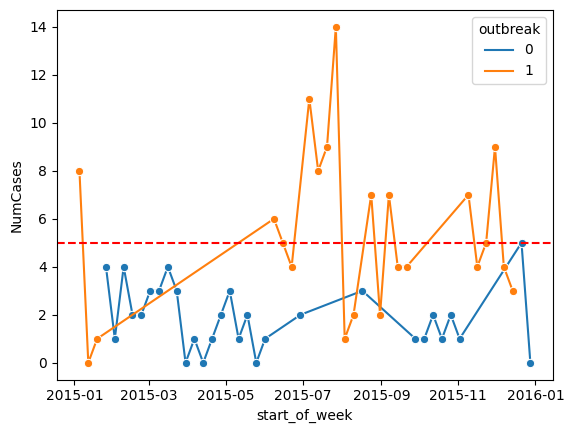

In [115]:
sns.lineplot(
    x="start_of_week",
    y="NumCases",
    data=brgy_weekly[
        (brgy_weekly["ADM4_PCODE"] == "PH097332087")
        & (brgy_weekly["start_of_week"].dt.year == 2015)
    ],
    hue="outbreak",
    marker="o",
)
# Plot the second line on the same axes
# sns.lineplot(x="start_of_week", y = "NumCases",
#              data = test2_copy[(test2_copy['ADM4_PCODE'] == 'PH097332087') &
#                                 (test2_copy['start_of_week'].dt.year==2013)])

# Add a horizontal line for the threshold
plt.axhline(5, color="red", linestyle="--", label="Threshold")
# Show the plot
plt.show()

In [123]:
outbreaks_weekly["year"] = outbreaks_weekly["start_of_week"].dt.year
outbreaks_weekly

/tmp/ipykernel_12084/2326024237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outbreaks_weekly['year'] = outbreaks_weekly['start_of_week'].dt.year


,start_of_week,ADM4_PCODE,NumCases,outbreak,year
64,2013-01-07,PH097332072,8.0,1,2013
68,2013-01-07,PH097332076,9.0,1,2013
79,2013-01-07,PH097332087,6.0,1,2013
148,2013-01-14,PH097332059,8.0,1,2013
154,2013-01-14,PH097332065,7.0,1,2013
...,...,...,...,...,...
34887,2019-11-25,PH097332072,2.0,1,2019
34902,2019-11-25,PH097332087,3.0,1,2019
35473,2020-01-06,PH097332076,7.0,1,2020
35570,2020-01-13,PH097332076,3.0,1,2020


## Get Outbreaks table

In [124]:
# Create a boolean mask for rows with outbreak_tag = 1
copy_brgy_weekly = brgy_weekly.copy()
copy_brgy_weekly.sort_values(by=["ADM4_PCODE", "start_of_week"], inplace=True)

outbreak_mask = copy_brgy_weekly["outbreak"] == 1

# Calculate a group ID for each consecutive outbreak period
# Calculate a group ID for each consecutive outbreak period within the same barangay
outbreak_groups = (outbreak_mask != outbreak_mask.shift(fill_value=False)).cumsum()
# Add the 'outbreak_groups' column to the DataFrame
copy_brgy_weekly["outbreak_group"] = outbreak_groups

In [125]:
# Filter rows with outbreak_tag = 1
outbreak_df = copy_brgy_weekly[outbreak_mask]

In [126]:
outbreak_df

,start_of_week,ADM4_PCODE,NumCases,outbreak,outbreak_group
6694,2014-05-05,PH097332002,8.0,1,1
6791,2014-05-12,PH097332002,3.0,1,1
6888,2014-05-19,PH097332002,3.0,1,1
7082,2014-06-02,PH097332002,6.0,1,3
7179,2014-06-09,PH097332002,6.0,1,3
...,...,...,...,...,...
33464,2019-08-12,PH097332104,0.0,1,539
33561,2019-08-19,PH097332104,1.0,1,539
33852,2019-09-09,PH097332104,6.0,1,541
33949,2019-09-16,PH097332104,1.0,1,541


In [127]:
# Group by 'barangay' and 'outbreak_group' and calculate start date, end date, and length
outbreak_summary = (
    outbreak_df.groupby(["ADM4_PCODE", "outbreak_group"])
    .agg(
        start_date=("start_of_week", "min"),
        end_date=("start_of_week", "max"),
        length_weeks=("outbreak", "count"),
    )
    .reset_index()
)

outbreak_summary.head(3)

,ADM4_PCODE,outbreak_group,start_date,end_date,length_weeks
0,PH097332002,1,2014-05-05,2014-05-19,3
1,PH097332002,3,2014-06-02,2014-08-04,10
2,PH097332002,5,2014-08-25,2014-09-08,3


In [128]:
outbreak_summary

,ADM4_PCODE,outbreak_group,start_date,end_date,length_weeks
0,PH097332002,1,2014-05-05,2014-05-19,3
1,PH097332002,3,2014-06-02,2014-08-04,10
2,PH097332002,5,2014-08-25,2014-09-08,3
3,PH097332002,7,2015-08-31,2015-09-14,3
4,PH097332002,9,2015-10-26,2015-11-09,3
...,...,...,...,...,...
266,PH097332101,533,2019-06-10,2019-06-24,3
267,PH097332103,535,2019-06-24,2019-07-08,3
268,PH097332104,537,2019-01-28,2019-02-11,3
269,PH097332104,539,2019-07-15,2019-08-19,6


In [129]:
outbreak_summary[outbreak_summary["ADM4_PCODE"] == "PH097332087"]

,ADM4_PCODE,outbreak_group,start_date,end_date,length_weeks
215,PH097332087,431,2013-01-07,2013-04-08,14
216,PH097332087,433,2013-04-22,2013-07-29,15
217,PH097332087,435,2013-08-19,2013-09-02,3
218,PH097332087,437,2014-02-24,2014-03-10,3
219,PH097332087,439,2014-05-12,2014-08-18,15
220,PH097332087,441,2014-09-01,2014-09-15,3
221,PH097332087,443,2014-10-13,2014-12-01,8
222,PH097332087,445,2015-01-05,2015-01-19,3
223,PH097332087,447,2015-06-08,2015-06-22,3
224,PH097332087,449,2015-07-06,2015-08-10,6


In [52]:
# grouped.to_csv(LGU_DIR/"outbreaks_weekly_zamboanga_v1.csv")